# Predicting the Sale Price of Bulldozers

This notebook is a project that predicts the sale price of bulldozers based on past sale data. This is an example of a supervised learning regression problem, since we are predicting a numerical value on a continuous scale.

## 1. Problem Definition
How accurately can we predict the sale price of bulldozers given past data.

## 2. Data
The data is from Kaggle, [Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data).

There are three data sets:
* train.csv - the training set.
* valid.csv - the validation set to fine tune the model.
* test.csv - the test set that was used to evaluate the model for the competition.

## 3. Evaluation
We will use the root mean square log error to evaluate the performance of our model. The goal is to minimize the error.

## 4. Features
Kaggle provides a detailed [data dictionary](https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing) outlining all of the features of the dataset.

### Explore the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

Plot the sale price vs the sale data as a scatter plot to see if there is any correlation.

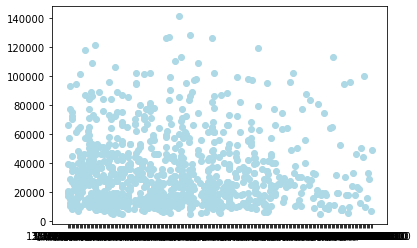

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000], color="lightblue")

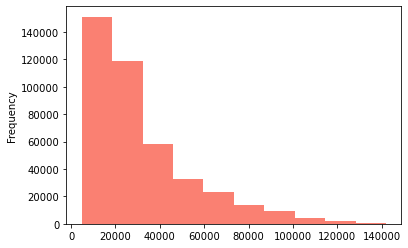

In [9]:
df.SalePrice.plot.hist(color="salmon");

### Parsing dates
We can change the sale date column into a datetime object in Python.

In [11]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

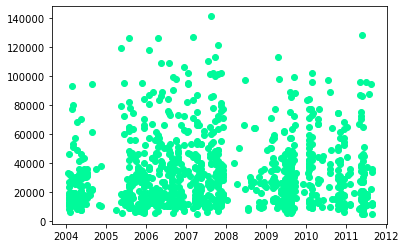

In [15]:
# Let's plot the sale price vs date again
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000], c='mediumspringgreen')

Now we can see the data being separated by years.

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sort the DataFrame by date
Since we'll be using historical sale data to predict future sales, we need to sort it by sale date.

In [17]:
df.sort_values(by=["saledate"], inplace=True)
df.head(20)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
54653,1301884,23500.0,1182999,4123,132,99.0,1976,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
81383,1379228,31000.0,1082797,7620,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
204924,1645390,11750.0,1527216,8202,132,99.0,1970,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
135376,1493279,63000.0,1363756,2759,132,99.0,1987,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
113390,1449549,13000.0,1289412,3356,132,99.0,1966,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Make a copy of the DataFrame
Since we'll be manipulating the date, we will need to make a copy of the dataframe in case we need the original again.

In [18]:
df_temp = df.copy()

### Add datetime parameters
This is so we can be more precise with the dates we are using, so we can separate the  year, month, etc., and add it to the dataframe.

In [19]:
df_temp["saleYear"] = df_temp.saledate.dt.year
df_temp["saleMonth"] = df_temp.saledate.dt.month
df_temp["saleDay"] = df_temp.saledate.dt.day
df_temp["saleDayOfWeek"] = df_temp.saledate.dt.dayofweek
df_temp["saleDayOfYear"] = df_temp.saledate.dt.dayofyear

# Drop the original date
df_temp.drop("saledate", axis=1, inplace=True)

In [20]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [21]:
df_temp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling
Before we can start modelling, we need to make sure we have the necessary data that the model can work with.

Using `df.isna().sum()` we can see that there are lots of columns with missing data that we need to fill in.

In [22]:
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

And using `df.info()` we can see that there are columns with categorical data that the model wouldn't know how to use, so we need to convert them into integer values.

In [23]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

### Converting strings into categories
We can use the pandas types API to manipulate the types of data.

`pd.api.types.is_string_dtype()` determines if the datatype of the column is a string. We can use that to find all columns that contain strings.

In [24]:
# This will turn all of the string values into category values
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [25]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

### Save the processed data
We can save the data we processed so we can load it up again at a later time.

In [26]:
# Save processed data
df_temp.to_csv("data/train_temp.csv", index=False)

In [4]:
# Code to import the data
df_temp = pd.read_csv("data/train_temp.csv", low_memory=False)

## Fill missing values

We need two things before we can model:
1. All data must be numerical
2. There are no missing values

### Filling numerical values
Check which columns have missing numerical data. We can fill those with the median of the column.

In [5]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
##            df_temp[label+"_is_missing"] = pd.isnull(content)
            
            df_temp[label] = content.fillna(content.median())

We now have extra columns that tell us whether the values in those columns were missing or not.

In [6]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,0,0,0,0,0
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Filling and turning categorical values to numbers

In [7]:
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
##        df_temp[label+"is_missing"] = pd.isnull(content)
        
        df_temp[label] = pd.Categorical(content).codes+1

We add "+1" as the end because pandas encodes missing values as -1.

In [8]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              412698 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  412698 non-null  float64
 8   UsageBand                 412698 non-null  int8   
 9   fiModelDesc               412698 non-null  int16  
 10  fiBaseModel               412698 non-null  int16  
 11  fiSecondaryDesc           412698 non-null  int16  
 12  fiModelSeries             412698 non-null  int8   
 13  fiModelDescriptor         412698 non-null  i

In [9]:
df_temp.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

In [10]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,8,6,0,0,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,0,0,4,2,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,8,6,0,0,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,0,0,4,2,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,6,5,0,0,1989,1,31,1,31


## Splitting into training and validation datasets

In [11]:
df_temp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

Training set contains all samples until 2012, and validation set will contain all samples after 2012.

In [13]:
df_valid = df_temp[df_temp.saleYear == 2012]
df_train = df_temp[df_temp.saleYear != 2012]

len(df_valid), len(df_train)

(11573, 401125)

In [14]:
# Split into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_valid.drop("SalePrice", axis=1), df_valid.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

## Building an evaluation function
Scikit-Learn has mean squared log error function, but we need the root mean squared log error, so we can write the code for it.

In [15]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

## Testing the model on a subset
Training the model on the entire dataset takes too long, so we need to use a subset of the data to tune the hyperparameters.

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

In [17]:
%%time
model.fit(X_train, y_train)

Wall time: 8.86 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [18]:
show_scores(model)

{'Training MAE': 5555.290898074167,
 'Valid MAE': 7143.908311587315,
 'Training RMSLE': 0.2578673284790509,
 'Valid RMSLE': 0.2935112108498018,
 'Training R^2': 0.8608829946864367,
 'Valid R^2': 0.8342179138796334}

## Tuning hyperparameters with RandomizedSearchCV

In [19]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.8min finished


Wall time: 9min


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [20]:
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 16,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [21]:
# Evaluare with best parameters
show_scores(rs_model)

{'Training MAE': 6565.623392970631,
 'Valid MAE': 8122.880077884602,
 'Training RMSLE': 0.29415080717359743,
 'Valid RMSLE': 0.32312579018964827,
 'Training R^2': 0.8058915971783956,
 'Valid R^2': 0.7761014803284836}

## Train a model with best parameters
Let's instantiate a model with the best hyperparameters

In [37]:
%%time

ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)

ideal_model.fit(X_train, y_train)

Wall time: 1min 47s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [38]:
show_scores(ideal_model)

{'Training MAE': 2927.9193484909674,
 'Valid MAE': 5906.176935237084,
 'Training RMSLE': 0.14332932666525947,
 'Valid RMSLE': 0.24488868862885357,
 'Training R^2': 0.9597326534603731,
 'Valid R^2': 0.8836050140021299}

In [30]:
# Save the model so we can load it faster
from joblib import dump
dump(ideal_model, "ideal-model.joblib")

['ideal-model.joblib']

## Making predictions on test data

In [ ]:
# Load saved model
from joblib import load
ideal_model = load("ideal-model.joblib")

In [27]:
df_test = pd.read_csv("data/Test.csv", parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing data
We need this to make sure our test data matches our training and validation data.

In [28]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
##                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
##            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

In [29]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,0,0,0,0,0,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,0,0,0,3,2,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,0,0,0,0,0,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,0,0,0,0,0,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,1,4,5,0,0,2012,5,10,3,131


In [41]:
# Try to predict
test_preds = ideal_model.predict(df_test)

In [42]:
test_preds

array([18105.14723335, 17719.35964556, 46324.42245559, ...,
       12766.2049211 , 17579.23221471, 25509.24975388])

In [43]:
# Create a DataFrame to submit to Kaggle
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,18105.147233
1,1227844,17719.359646
2,1227847,46324.422456
3,1227848,60987.323664
4,1227863,57337.579147
...,...,...
12452,6643171,41598.190032
12453,6643173,12974.157564
12454,6643184,12766.204921
12455,6643186,17579.232215


In [44]:
# Export to csv
df_preds.to_csv("data/predictions.csv", index=False)

## Feature Importance
**Feature importance** shows which features had a bigger effect on the predictions.

In [45]:
# Find feature importance of the model
ideal_model.feature_importances_

array([3.47531431e-02, 2.10036205e-02, 4.69609008e-02, 2.12054235e-03,
       3.40012939e-03, 1.97734820e-01, 3.31120411e-03, 1.16760965e-03,
       3.93472093e-02, 4.13561138e-02, 6.54947995e-02, 5.43648334e-03,
       2.41734298e-02, 1.58238735e-01, 4.81674587e-02, 6.00958079e-03,
       4.92642481e-03, 6.70777024e-03, 3.30270129e-03, 8.31869588e-02,
       8.01819533e-04, 2.27768077e-04, 1.38895136e-03, 2.74579019e-04,
       1.48194444e-03, 1.18097399e-04, 3.46401348e-03, 8.77807740e-03,
       3.07986470e-03, 2.42692796e-03, 8.09399988e-03, 6.47126727e-03,
       5.07081358e-03, 3.11001522e-03, 3.06005729e-03, 1.02088938e-02,
       1.29535387e-03, 1.68377744e-02, 1.06175050e-02, 7.25465156e-03,
       2.14825943e-03, 1.02195010e-03, 1.72463433e-03, 7.22440582e-04,
       9.21746861e-04, 3.84589193e-04, 4.45778304e-04, 3.32389223e-03,
       1.44171099e-03, 3.58551165e-04, 5.93300290e-04, 7.36637194e-02,
       3.82662211e-03, 5.69866548e-03, 2.91114629e-03, 9.95098273e-03])

In [48]:
import sys
!conda install --yes --prefix {sys.prefix} seaborn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\dilya\Desktop\MachineLearning\bulldozer-project\env

  added / updated specs:
    - seaborn


The following NEW packages will be INSTALLED:

  seaborn            pkgs/main/noarch::seaborn-0.10.1-py_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [49]:
import seaborn as sns

def plot_features(cols, importances, n=20):
    df = (pd.DataFrame({"features": cols,
                        "feature_importance": importances})
          .sort_values("feature_importance", 
                        ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

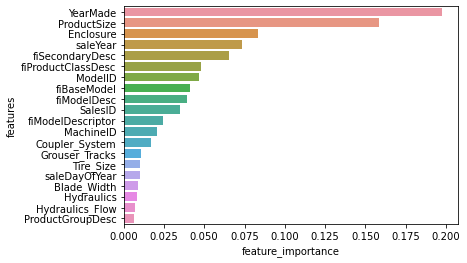

In [50]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [51]:
sum(ideal_model.feature_importances_)

1.0

Product size seems very important, so let's check if we had enouhg data to make accurate predictions.

In [52]:
df.ProductSize.isna().sum() / len(df)

0.5248511017741787

When we trained the model, half of the product size samples were not specified, so the predictions may not be completely accurate.